In [ ]:
!pip install torch_geometric

In [ ]:
import torch
import random
from torch_geometric.data import Data, Dataset
import networkx as nx
from torch_geometric.utils import from_networkx, negative_sampling,train_test_split_edges
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
#########################
###  Helper Functions ###
#########################

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

def visualize_training_validation_loss(training_loss, validation_loss):

    epochs = range(1, len(training_loss) + 1)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(epochs, training_loss, color='steelblue', linewidth=2.5, label='Training Loss')
    ax.plot(epochs, validation_loss, color='darkorange', linewidth=2.5, label='Validation Loss')
    ax.set_xlabel('Epoch', fontsize=14, labelpad=10)
    ax.set_ylabel('Loss', fontsize=14, labelpad=10)
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16, pad=20)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()


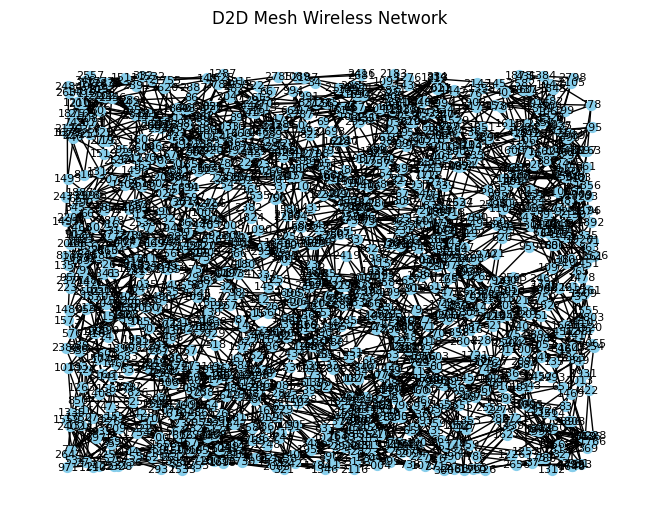

In [ ]:


# Global Variables
network_size = (100, 100)  # Size of the 2D space in meters
num_nodes = 3000 # Initial number of nodes

# Create a D2D mesh wireless network
G = nx.Graph()

# Add nodes with features
for i in range(num_nodes):
    position = (np.random.uniform(0, network_size[0]), np.random.uniform(0, network_size[1]))
    battery = np.random.uniform(0.1, 1)
    cpu = np.random.uniform(0.1, 1)
    memory = np.random.uniform(0.1, 1)
    bandwidth = np.random.uniform(10, 100) #MHz
    transmission_power = np.random.uniform(0.9, 1.2) # normally ~1mW

    G.add_node(i,
               position=position,
               battery=battery,
               cpu=cpu,
               memory=memory,
               bandwidth=bandwidth,
               transmission_power=transmission_power)

# Implement edge creation criteria
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 < node2:  # Avoid duplicate edges and self-loops
            dist = np.sqrt((G.nodes[node1]['position'][0] - G.nodes[node2]['position'][0])**2 +
                           (G.nodes[node1]['position'][1] - G.nodes[node2]['position'][1])**2)
            signal_strength = G.nodes[node1]['transmission_power'] / (dist**2)
            if 10 < dist < 50 and signal_strength > 0.008 and G.degree[node1] < 5 and G.degree[node2] < 5 and \
                    all(G.nodes[node]['battery'] > 0.3 for node in (node1, node2)) and \
                    all(G.nodes[node]['cpu'] < 0.8 for node in (node1, node2)) and \
                    all(G.nodes[node]['memory'] < 0.8 for node in (node1, node2)):
                G.add_edge(node1, node2)

# Discard nodes without neighbors
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# Keep only the largest subgraph
largest_subgraph_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_subgraph_nodes)


# Plot the graph based on position_x and position_y
pos = {node: G.nodes[node]['position'] for node in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
plt.title("D2D Mesh Wireless Network")
plt.show()

# Print the resulting number of nodes
print(f"Number of nodes after discarding isolated nodes and keeping largest subgraph: {G.number_of_nodes()}")

In [ ]:


#Extract attributes into lists
positions = [G.nodes[node]['position'] for node in G.nodes()]
batteries = [G.nodes[node]['battery'] for node in G.nodes()]
cpus = [G.nodes[node]['cpu'] for node in G.nodes()]
memories = [G.nodes[node]['memory'] for node in G.nodes()]
bandwidths = [G.nodes[node]['bandwidth'] for node in G.nodes()]
transmission_powers = [G.nodes[node]['transmission_power'] for node in G.nodes()]

#Convert lists to tensors
positions_tensor = torch.tensor(positions, dtype=torch.float32)
batteries_tensor = torch.tensor(batteries, dtype=torch.float32).view(-1, 1)
cpus_tensor = torch.tensor(cpus, dtype=torch.float32).view(-1, 1)
memories_tensor = torch.tensor(memories, dtype=torch.float32).view(-1, 1)
bandwidths_tensor = torch.tensor(bandwidths, dtype=torch.float32).view(-1, 1)
transmission_powers_tensor = torch.tensor(transmission_powers, dtype=torch.float32).view(-1, 1)

#Concatenate tensors to get the node feature tensor
x = torch.cat([positions_tensor, batteries_tensor, cpus_tensor, memories_tensor, bandwidths_tensor, transmission_powers_tensor], dim=1)

data = from_networkx(G)
attributes_to_remove = ['position', 'battery', 'cpu', 'memory', 'bandwidth', 'transmission_power', 'num_nodes']

for attr in attributes_to_remove:
    if hasattr(data, attr):
        delattr(data, attr)

data.x = x
edge_index = data.edge_index



Number of nodes after discarding isolated nodes and keeping largest subgraph: 1392


In [ ]:
data = train_test_split_edges(data)
data.edge_index = edge_index
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[1392, 7], val_pos_edge_index=[2, 155], test_pos_edge_index=[2, 310], train_pos_edge_index=[2, 5278], train_neg_adj_mask=[1392, 1392], val_neg_edge_index=[2, 155], test_neg_edge_index=[2, 310], edge_index=[2, 6208])

**Targets for the Link Prediction Task**

Forget the 1) it will not perform well

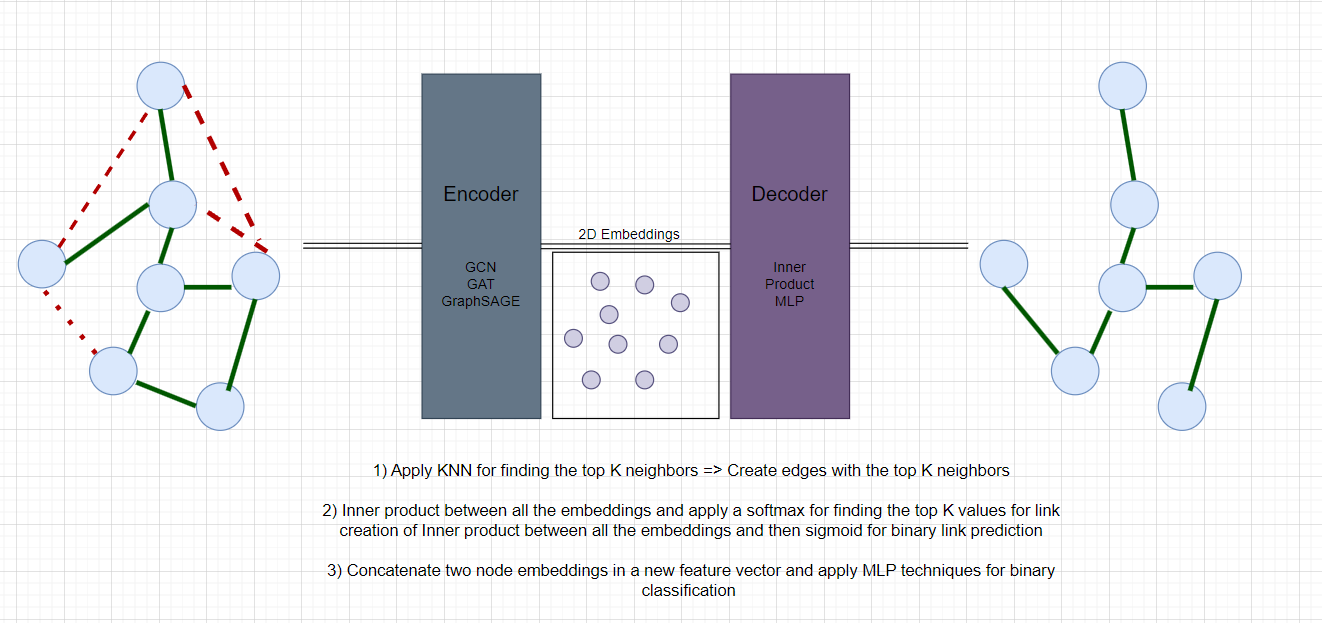

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=F.relu):
        super(GCN, self).__init__()

        self.activation = activation
        self.dropout_rate = 0.5

        # Layers
        self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dims[0])])
        #self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dims[0])])
        #self.dropouts = torch.nn.ModuleList([torch.nn.Dropout(self.dropout_rate)])

        # Add the hidden layers
        for i in range(1, len(hidden_dims)):
            self.convs.append(GCNConv(hidden_dims[i-1], hidden_dims[i]))
            #self.bns.append(torch.nn.BatchNorm1d(hidden_dims[i]))
            #self.dropouts.append(torch.nn.Dropout(self.dropout_rate))

        # Define the final convolution layer
        self.convs.append(GCNConv(hidden_dims[-1], output_dim))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            #x = self.bns[i](x)
            x = self.activation(x)
            #x = self.dropouts[i](x)

        # Apply final layer without activation
        x = self.convs[-1](x, edge_index)
        return x


In [ ]:

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=F.relu):
        super(GraphSAGE, self).__init__()

        self.activation = activation
        self.dropout_rate = 0.5

        # Define the initial convolution layer
        self.convs = torch.nn.ModuleList([SAGEConv(input_dim, hidden_dims[0])])
        #self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dims[0])])
        #self.dropouts = torch.nn.ModuleList([torch.nn.Dropout(self.dropout_rate)])

        # Add the hidden layers
        for i in range(1, len(hidden_dims)):
            self.convs.append(SAGEConv(hidden_dims[i-1], hidden_dims[i]))
            #self.bns.append(torch.nn.BatchNorm1d(hidden_dims[i]))
            #self.dropouts.append(torch.nn.Dropout(self.dropout_rate))

        # Define the final convolution layer
        self.convs.append(SAGEConv(hidden_dims[-1], output_dim))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            #x = self.bns[i](x)
            x = self.activation(x)
            #x = self.dropouts[i](x)

        # Apply final layer without activation
        x = self.convs[-1](x, edge_index)
        return x


In [ ]:
#TODO GAT

In [ ]:

def train(model, data, optimizer, epochs):

    training_loss = []
    validation_loss = []

    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()

        # Obtain the embeddings for all nodes
        z = model(data.x, data.edge_index)

        #visualize_embedding(z, "lightblue", epoch=None, loss=None)

        # Positive samples
        pos_loss = F.binary_cross_entropy_with_logits((z[data.train_pos_edge_index[0]] * z[data.train_pos_edge_index[1]]).sum(dim=-1),torch.ones(data.train_pos_edge_index.size(1)))

        # Negative samples
        neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index,num_nodes=data.num_nodes,num_neg_samples=data.train_pos_edge_index.size(1))

        neg_loss = F.binary_cross_entropy_with_logits((z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1),torch.zeros(neg_edge_index.size(1)))

        loss = pos_loss + neg_loss
        training_loss.append(loss.item())
        validation_loss.append(validate(model, data))

        loss.backward()
        optimizer.step()

    return model, training_loss, validation_loss


In [ ]:
def validate(model, data):

    model.eval()

    with torch.no_grad():

        z = model(data.x, data.edge_index)

        # Positive samples loss for validation set
        pos_val_loss = F.binary_cross_entropy_with_logits((z[data.val_pos_edge_index[0]] * z[data.val_pos_edge_index[1]]).sum(dim=-1),torch.ones(data.val_pos_edge_index.size(1)))

        # Negative samples for validation set
        neg_val_edge_index = negative_sampling(edge_index=data.val_pos_edge_index,num_nodes=data.num_nodes,num_neg_samples=data.val_pos_edge_index.size(1))

        neg_val_loss = F.binary_cross_entropy_with_logits((z[neg_val_edge_index[0]] * z[neg_val_edge_index[1]]).sum(dim=-1),torch.zeros(neg_val_edge_index.size(1)))

        total_val_loss = pos_val_loss + neg_val_loss

    return total_val_loss.item()


In [ ]:

def test_accuracy(model, data, threshold=0.5):

    model.eval()

    with torch.no_grad():
        # Obtain the embeddings for all nodes
        z = model(data.x, data.edge_index)

        # Positive samples prediction for test set
        pos_pred = torch.sigmoid((z[data.test_pos_edge_index[0]] * z[data.test_pos_edge_index[1]]).sum(dim=-1))
        pos_target = torch.ones(data.test_pos_edge_index.size(1))

        # Negative samples for test set
        neg_pred = torch.sigmoid((z[data.test_neg_edge_index[0]] * z[data.test_neg_edge_index[1]]).sum(dim=-1))
        neg_target = torch.zeros(data.test_neg_edge_index.size(1))

        # Concatenate results
        preds = torch.cat([pos_pred, neg_pred])
        targets = torch.cat([pos_target, neg_target])

        # Compute predictions based on the threshold
        preds_binary = (preds > threshold).float()

        # Compute accuracy
        correct_predictions = (preds_binary == targets).sum().item()
        total_predictions = targets.size(0)
        accuracy = correct_predictions / total_predictions

    return z, accuracy


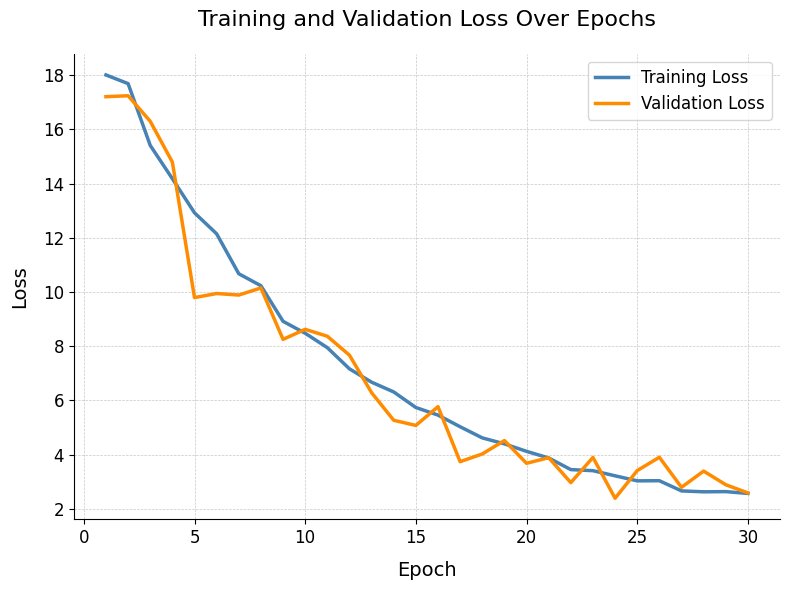

Classification Accuracy: 0.6532258064516129


In [ ]:


#############   Hyperparameters to tune  #################
EPOCHS = 30
LR = 0.01
HIDDEN_DIM = [4]            # One hidden dimension that outputs embeddings with 4 features
OUTPUT_DIM = 2              # Dimension of the output embedding
ACTIVATION = F.relu

model = GCN(data.num_features, HIDDEN_DIM, OUTPUT_DIM, ACTIVATION)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

##########################################################

model, training_loss, validation_loss = train(model, data, optimizer, epochs=EPOCHS)
visualize_training_validation_loss(training_loss, validation_loss)
z, classification_score = test_accuracy(model, data, threshold=0.5)
print("Classification Accuracy:", classification_score)


In [ ]:

######################    Apply Machine Learning For Link Classification     #################################

concatenated_train_pos_embeddings = torch.cat([z[data.train_pos_edge_index[0]], z[data.train_pos_edge_index[1]]], dim=1)
concatenated_val_pos_embeddings = torch.cat([z[data.val_pos_edge_index[0]], z[data.val_pos_edge_index[1]]], dim=1)
pos_training_data = torch.cat([concatenated_train_pos_embeddings, concatenated_val_pos_embeddings], dim=0)
labels = torch.ones(pos_training_data.shape[0], 1)
positive_edges = torch.cat([pos_training_data, labels], dim=1)

neg_train_edge_index = negative_sampling(edge_index=data.train_pos_edge_index,num_nodes=data.num_nodes,num_neg_samples=data.train_pos_edge_index.size(1))
neg_val_edge_index = negative_sampling(edge_index=data.val_pos_edge_index,num_nodes=data.num_nodes,num_neg_samples=data.val_pos_edge_index.size(1))
concatenated_train_neg_embeddings = torch.cat([z[neg_train_edge_index[0]], z[neg_train_edge_index[1]]], dim=1)
concatenated_val_neg_embeddings = torch.cat([z[neg_val_edge_index[0]], z[neg_val_edge_index[1]]], dim=1)
neg_training_data = torch.cat([concatenated_train_neg_embeddings, concatenated_val_neg_embeddings], dim=0)
neg_labels = torch.zeros(neg_training_data.shape[0], 1)
negative_edges = torch.cat([neg_training_data, neg_labels], dim=1)



training_data = torch.cat([positive_edges, negative_edges], dim=0)
perm = torch.randperm(training_data.size(0))
training_data = training_data[perm]

X = training_data[:, :-1].cpu().numpy()
y = training_data[:, -1].cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)


In [ ]:

def tsne_2d_visualization(data, labels):

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(data)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)
    plt.title("t-SNE 2D visualization of the data")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()


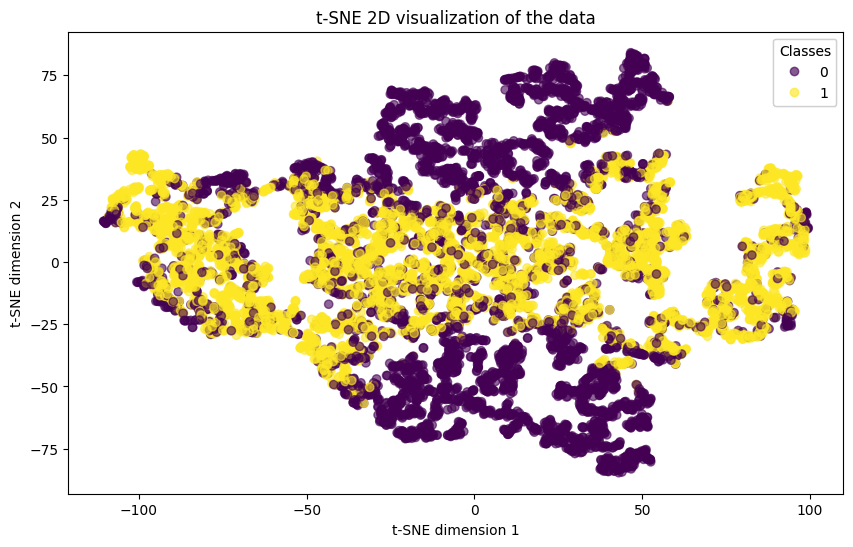

In [ ]:
tsne_2d_visualization(X, y)


In [ ]:

def train_and_test(X, y, algorithm=None):
    if algorithm == "logistic_regression":
        clf = LogisticRegression(random_state=42)
    elif algorithm == "svm":
        clf = SVC(random_state=42)
    elif algorithm == "decision_tree":
        clf = DecisionTreeClassifier(random_state=42)
    elif algorithm == "random_forest":
        clf = RandomForestClassifier(random_state=42)
    elif algorithm == "knn":
        clf = KNeighborsClassifier()
    elif algorithm == "gradient_boosted_trees":
        clf = GradientBoostingClassifier(random_state=42)
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    metrics = {
        "accuracy": cross_val_score(clf, X, y, cv=kf, scoring='accuracy').mean(),
        "precision": cross_val_score(clf, X, y, cv=kf, scoring='precision').mean(),
        "recall": cross_val_score(clf, X, y, cv=kf, scoring='recall').mean(),
        "f1": cross_val_score(clf, X, y, cv=kf, scoring='f1').mean()
    }


    return clf, metrics



In [ ]:
clf, metrics = train_and_test(X, y, algorithm="knn")
print(f"Metrics of random_forest: {metrics}")


Metrics of random_forest: {'accuracy': 0.7136013998004277, 'precision': 0.6727247397767764, 'recall': 0.8318620204689576, 'f1': 0.7438029845304264}


In [ ]:


class linkPrediction_Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)

# Create dataset
dataset = linkPrediction_Data(X_tensor, y_tensor)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


#########################  Parameters  #####################################3
input_size = X.shape[1]
learning_rate = 0.01
num_epochs = 50
barch_size = 32


# Create dataloaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=barch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=barch_size, shuffle=False)


# Initialize the model, loss and optimizer
model = BinaryClassifier(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

all_predictions = []
all_true_labels = []

# Evaluate on test set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = (outputs > 0.5).float()
        all_predictions.extend(predicted.view(-1).tolist())
        all_true_labels.extend(y_batch.view(-1).tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([int(pred == true) for pred, true in zip(all_predictions, all_true_labels)]) / len(all_true_labels)
precision = precision_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

print(f"Accuracy on test set: {accuracy:.2f}%")
print(f"Precision on test set: {precision:.2f}")
print(f"Recall on test set: {recall:.2f}")
print(f"F1 Score on test set: {f1:.2f}")


Epoch 0/50, Loss: 0.4603
Epoch 10/50, Loss: 0.5993
Epoch 20/50, Loss: 0.3409
Epoch 30/50, Loss: 0.6353
Epoch 40/50, Loss: 0.5175
Training complete!
Accuracy on test set: 74.56%
Precision on test set: 0.72
Recall on test set: 0.81
F1 Score on test set: 0.76
